In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from numba import njit
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge

In [2]:
matdata = loadmat('Data/Lab 3/ex3data1.mat')

In [3]:
def prep_data(suf='', degree=1, data=matdata):
    x = data['X'+suf]
    y = data['y'+suf]
    
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    
    poly = PolynomialFeatures(degree=degree)
    x = poly.fit_transform(x)
    
    m, n = x.shape
    return x, y, m, n, poly

In [4]:
def h(θ, x):
    """
        Parameters
        ----------
        θ: array, shape (n, )
        x: array, shape (m, n)
        
        Returns
        -------
        h: array, shape (m, 1)
    """
    m = len(x)
    return x.dot(θ).reshape(m, 1)


def COST_F(θ, x, y):
    """
        Parameters
        ----------
        θ: array, shape (n, )
        x: array, shape (m, n)
        y: array, shape (m, 1)
        
        Returns
        -------
        cost: array, shape (m, 1)
    """
    m = len(x)
    cost = 0.5 * (h(θ, x) - y)**2
    return cost
    

def J_F(θ, x, y, λ):
    """
        Parameters
        ----------
        θ: array, shape (n, )
        x: array, shape (m, n)
        y: array, shape (m, 1)
        λ: number
        
        Returns
        -------
        J: number
    """
    cost = COST_F(θ, x, y)
    return cost.mean() + λ * (θ[1:]**2).sum()


def GD(θ, x, y, λ, α, ϵ):
    """
        Parameters
        ----------
        θ: array, shape (n, )
        x: array, shape (m, n)
        y: array, shape (m, 1)
        λ: number
        α: number
        ϵ: number
        
        Returns
        -------
        θ: array, shape (n, )
    """
    m, n = x.shape
    for i in range(10**5):
        Δ = h(θ, x) - y
        
        θ_new = np.zeros(n, dtype=np.float64)
        θ_new[0] = θ[0] - α * (Δ*x[:, [0]]).mean()
        for j in range(1, n):
            θ_new[j] = θ[j]*(1-α*λ/m) - α*(Δ*x[:,[j]]).mean()
        
        J_θ = J_F(θ, x, y, λ)
        J_θ_new = J_F(θ_new, x, y, λ)
        ΔJ = J_θ - J_θ_new 
        
        if ΔJ < 0:
            α /= 3
            continue
        elif ΔJ < ϵ:
            break
        
        θ = θ_new
        
#     print(f'GD niter: {i}')
    return θ


class LinearRegressionModel:
        
    def fit(self, *, x, y, λ=0, α=3, ϵ=1e-9, θ_zero=None):
        self.λ = λ
        self.x, self.y = x, y
        self.m, self.n = self.x.shape
        
#         model = Ridge(alpha=self.λ, solver='lsqr').fit(x, y)
#         self.θ = model.coef_[0]
        
        θ_zero = θ_zero or np.random.random(self.n)
        self.θ = GD(θ_zero, self.x, self.y, λ=λ, α=α, ϵ=ϵ)
        return self

    def curve(self, poly, x0, x1, step=1):
        assert self.θ is not None
        x = np.vstack(np.arange(x0, x1, step))
        y = poly.fit_transform(x).dot(self.θ)
        return x, y
    
    def predict(self, x):
        return x.dot(self.θ)

In [5]:
X, Y, M, N, poly = prep_data()
Xval, Yval, Mval, Nval, poly_val = prep_data(suf='val')
Xtest, Ytest, Mtest, Ntest, poly_test = prep_data(suf='test')

In [6]:
model = LinearRegressionModel().fit(x=X, y=Y)

In [7]:
x, y = model.curve(poly, 0, 1.1, 0.01)

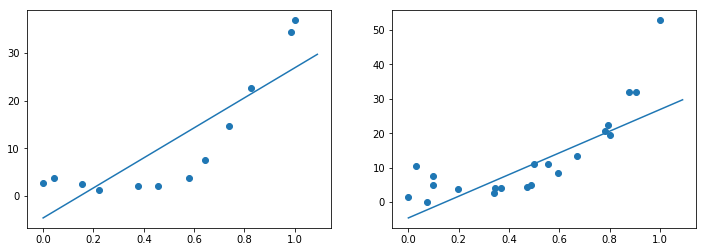

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(X.T[1], Y.T[0])
ax[0].plot(x, y)

ax[1].scatter(Xval.T[1], Yval.T[0])
ax[1].plot(x, y)

(22.37390650072275, 31.67252728130206)

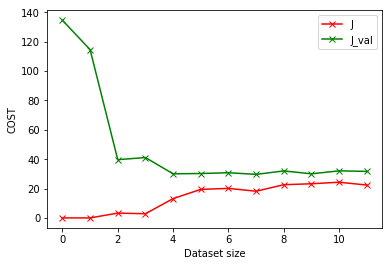

In [9]:
err, err_val = np.zeros(M), np.zeros(M)
for i in range(1, M+1):
    x_train, y_train = X[:i], Y[:i]
    model = LinearRegressionModel().fit(x=x_train, y=y_train)

    err[i-1] = J_F(model.θ, x_train, y_train, λ=model.λ)
    err_val[i-1] = J_F(model.θ, Xval, Yval, λ=model.λ)

fig, ax = plt.subplots()
ax.plot(err, label='J', marker='x', c='red')
ax.plot(err_val, label='J_val', marker='x', c='green')

ax.set_xlabel('Dataset size')
ax.set_ylabel('COST')

plt.legend()

err[-1], err_val[-1]

In [10]:
degree = 8
X, Y, M, N, poly = prep_data(degree=degree)
Xval, Yval, Mval, Nval, poly_val = prep_data(suf='val', degree=degree)
Xtest, Ytest, Mtest, Ntest, poly_test = prep_data(suf='val', degree=degree)

In [11]:
model = LinearRegressionModel().fit(x=X, y=Y)
x, y = model.curve(poly, 0, 1.05, 0.01)

(0.208751457738129, 14.280393259311335)

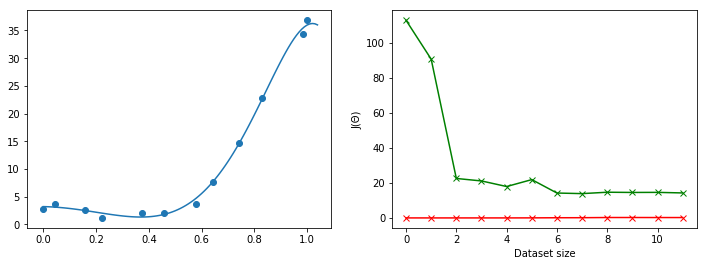

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].scatter(X.T[1], Y.T[0])
ax[0].plot(x, y)

err, err_val = np.zeros(M), np.zeros(M)
for i in range(1, M+1):
    x_train, y_train = X[:i], Y[:i]
    model = LinearRegressionModel().fit(x=x_train, y=y_train)
    
    err[i-1] = J_F(model.θ, x_train, y_train, λ=model.λ)
    err_val[i-1] = J_F(model.θ, Xval, Yval, λ=model.λ)

ax[1].plot(err, label='J', marker='x', c='red')
ax[1].plot(err_val, label='J_val', marker='x', c='green')
ax[1].set_xlabel('Dataset size')
ax[1].set_ylabel('J(Θ)')

err[-1], err_val[-1]

In [13]:
model_1 = LinearRegressionModel().fit(x=X, y=Y, λ=1)
x1, y1 = model_1.curve(poly, 0, 1.05, 0.01)

model_100 = LinearRegressionModel().fit(x=X, y=Y, λ=100)
x100, y100 = model_100.curve(poly, 0, 1.05, 0.01)

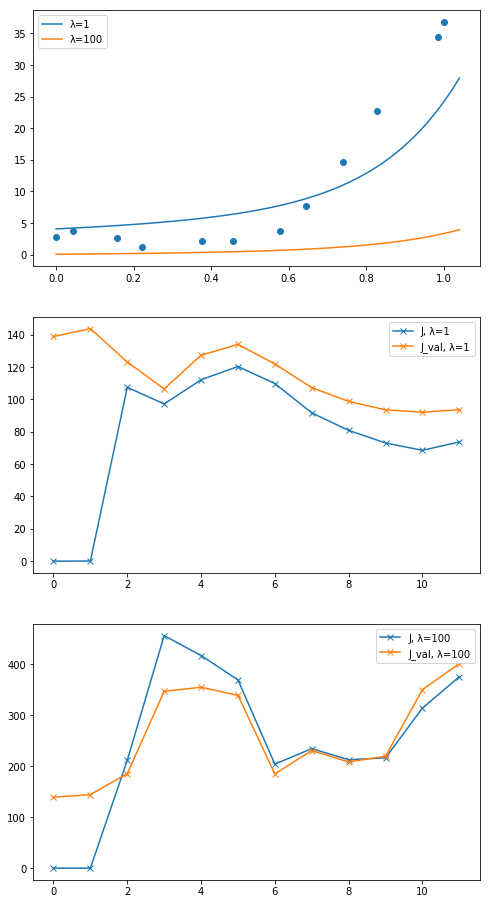

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(8,16))

ax[0].scatter(X.T[1], Y.T[0])
ax[0].plot(x1, y1, label='λ=1')
ax[0].plot(x100, y100, label='λ=100')
ax[0].legend()

err_1, err_val_1 = np.zeros(M), np.zeros(M)
err_100, err_val_100 = np.zeros(M), np.zeros(M)
for i in range(1, M+1):
    x_train, y_train = X[:i], Y[:i]
    
    model_1 = LinearRegressionModel().fit(x=x_train, y=y_train, λ=1)
    err_1[i-1] = J_F(model_1.θ, x_train, y_train, λ=model_1.λ)
    err_val_1[i-1] = J_F(model_1.θ, Xval, Yval, λ=model_1.λ)
    
    model_100 = LinearRegressionModel().fit(x=x_train, y=y_train, λ=100)
    err_100[i-1] = J_F(model_100.θ, x_train, y_train, λ=model_100.λ)
    err_val_100[i-1] = J_F(model_100.θ, Xval, Yval, λ=model_100.λ)
    

ax[1].plot(err_1, marker='x', label='J, λ=1')
ax[1].plot(err_val_1, marker='x', label='J_val, λ=1')
ax[1].legend()

ax[2].plot(err_100, marker='x', label='J, λ=100')
ax[2].plot(err_val_100, marker='x', label='J_val, λ=100')
ax[2].legend()

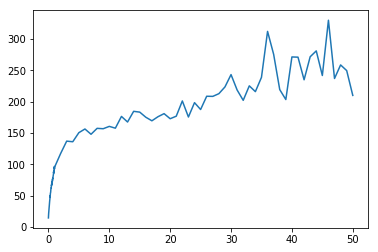

In [15]:
Λ = np.concatenate((np.arange(0, 1, 0.01), np.arange(1, 51)))
err_val = np.zeros(len(Λ))
for i, λ in enumerate(Λ):
    model = LinearRegressionModel().fit(x=X, y=Y, λ=λ)
    err_val[i] = J_F(model.θ, Xval, Yval, λ=model.λ)

fig, ax = plt.subplots()
ax.plot(Λ, err_val)

In [16]:
err_val

array([ 14.28049118,  17.21871873,  18.75290596,  20.16838196,
        21.54023922,  22.84781394,  24.09896575,  25.29121758,
        26.62395114,  27.82570718,  28.83859094,  30.12817701,
        31.2966344 ,  32.29078497,  34.16275735,  35.47033073,
        36.93032882,  37.78376865,  38.41589241,  39.71362888,
        40.25438312,  41.86156376,  42.39389342,  43.95103879,
        43.76369643,  45.57312135,  45.74545862,  49.91084632,
        47.26430399,  49.7721966 ,  51.85467421,  52.57565369,
        52.95713095,  53.59402388,  54.75696288,  54.67422035,
        55.39976089,  55.60455181,  58.20490258,  58.43682431,
        59.51207564,  60.30504744,  61.440025  ,  61.45030525,
        61.99355446,  61.87338896,  63.87499067,  63.61727056,
        64.33863101,  66.21244202,  66.52820862,  65.81811075,
        67.25992873,  68.65733847,  67.46679682,  69.80038008,
        68.87537032,  70.13681051,  71.34444376,  71.25283382,
        70.82800632,  71.43451843,  72.7364244 ,  72.74